This notebook:
1. Uses the CCI integrated dataset.
2. Filters to diabetes patients.
3. Runs VAE and TabNet with parameter input_file.
4. Performs clustering analysis and visualization (t-SNE, UMAP) as before.

In [1]:
# diabetes_subset_analysis.ipynb
# Author: Imran Feisal
# Date: 28/12/2024
# 
# This notebook:
# 1) Loads the CCI-integrated data from the parent Data directory.
# 2) Filters patients to those with 'diabetes' in the conditions description.
# 3) Saves the subset to a new .pkl file in the same Data directory.
# 4) Runs VAE and TabNet on the subset (the scripts will generate 
#    latent_features_vae.csv and tabnet_predictions.csv in the *local* folder).
# 5) Reads the resulting CSVs from the local folder (Diabetes Subset),
#    *without* moving or renaming them.
# 6) Clusters and visualizes the diabetes-only data similarly to the main notebook.

import os
import sys
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from scipy.stats import f_oneway, kruskal, shapiro, levene
from mpl_toolkits.mplot3d import Axes3D  # For 3D plots

# -----------------------------------------------------------------------------
# 1) Locate Project & Data Directories
# -----------------------------------------------------------------------------
# If your main project is two levels up, adjust as needed:
project_dir = os.path.abspath(os.path.join("..", ".."))  
data_dir = os.path.join(project_dir, "Data")

# Add project folder to sys.path so we can import vae_model, tabnet_model, etc.
sys.path.append(project_dir)

# -----------------------------------------------------------------------------
# 2) Imports for VAE and TabNet (scripts must be accessible in project_dir)
# -----------------------------------------------------------------------------
from vae_model import main as vae_main
from tabnet_model import main as tabnet_main

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("Project directory:", project_dir)
print("Data directory:", data_dir)


Project directory: c:\Users\imran\Documents\VITAI
Data directory: c:\Users\imran\Documents\VITAI\Data


### Load CCI-Integrated Dataset

In [2]:
cci_file = "patient_data_with_health_index_cci.pkl"
cci_path = os.path.join(data_dir, cci_file)
if not os.path.exists(cci_path):
    raise FileNotFoundError(f"CCI file not found at {cci_path}. "
                            "Please run the main notebook or script to generate it first.")

patient_data = pd.read_pickle(cci_path)
print("Loaded CCI dataset. Shape:", patient_data.shape)
patient_data.head()

Loaded CCI dataset. Shape: (234458, 18)


,Id,MARITAL,RACE,ETHNICITY,GENDER,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,INCOME,AGE,DECEASED,AGE_AT_DEATH,SEQUENCE,Comorbidity_Score,Hospitalizations_Count,Medications_Count,Abnormal_Observations_Count,Health_Index,CharlsonIndex
0,2237e2d6-4755-bef8-d3d5-c718f8a0d98e,Unknown,white,nonhispanic,F,4681.49,142.36,167799,1.152635,0,1.152635,"[[0, 738, 1152, 1153, 1154, 1155, 1156, 1157, ...",6.0,0.0,1.0,3,1.014717,0.0
1,6865616f-0f82-ca17-f133-e14a9d220ee4,Unknown,white,nonhispanic,F,17768.36,0.00,36182,9.341547,0,9.341547,"[[0, 1152, 1153, 1154, 1155, 1156, 1157, 1158,...",10.0,0.0,1.0,24,1.066265,0.0
2,4a425864-327f-9bce-8ee4-9a2dc7498eb5,Unknown,black,nonhispanic,M,10064.69,5326.86,143562,10.009582,0,10.009582,"[[0, 738, 1152, 1153, 1154, 1155, 1156, 1157, ...",9.0,0.0,0.0,36,1.088778,0.0
3,1f370f41-c89b-e5ea-80b4-16462d29f73d,Unknown,white,nonhispanic,M,34082.86,10990.01,40518,16.235455,0,16.235455,"[[0], [1152, 1153, 1154, 1178, 1179, 1158, 115...",14.0,0.0,3.0,19,1.066220,0.0
4,6f117f2d-2916-9866-258c-bf26cff3aefc,Unknown,white,hispanic,F,2816.47,43878.80,9458,16.005476,0,16.005476,"[[0], [1, 748, 1174], [1, 1174], [738, 1152, 1...",15.0,0.0,2.0,7,1.039107,0.0


### Filter to diabetes patients

In [3]:
conditions_file = os.path.join(data_dir, "conditions.csv")
if not os.path.exists(conditions_file):
    raise FileNotFoundError(f"Conditions file not found at {conditions_file}.")

conditions = pd.read_csv(conditions_file, usecols=['PATIENT','DESCRIPTION'])

# We'll match any row containing the substring 'diabetes' in the description
# (case-insensitive).
diabetes_mask = conditions['DESCRIPTION'].str.lower().str.contains('diabetes', na=False)
diabetes_patients = conditions.loc[diabetes_mask, 'PATIENT'].unique()

print(f"Number of condition records: {len(conditions)}")
print(f"Conditions referencing 'diabetes': {diabetes_mask.sum()}")
print(f"Unique diabetes patients: {len(diabetes_patients)}")

# Subset the main dataset
subset_data = patient_data[patient_data['Id'].isin(diabetes_patients)].copy()
print("Subset shape (diabetes only):", subset_data.shape)
subset_data.head(3)

Number of condition records: 9686396
Conditions referencing 'diabetes': 213948
Unique diabetes patients: 107843
Subset shape (diabetes only): (107843, 18)


,Id,MARITAL,RACE,ETHNICITY,GENDER,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,INCOME,AGE,DECEASED,AGE_AT_DEATH,SEQUENCE,Comorbidity_Score,Hospitalizations_Count,Medications_Count,Abnormal_Observations_Count,Health_Index,CharlsonIndex
17,b45ca1e6-b6f2-58be-18d2-ce3af4180fe9,M,white,nonhispanic,M,104606.48,6077.88,156442,44.785763,0,44.785763,"[[23], [63, 39], [64], [0, 24, 30, 360, 361], ...",23.0,0.0,3.0,25,1.095553,0.0
21,7f1b3431-02ce-ba04-b450-6637f4562320,M,black,nonhispanic,M,178773.77,33842.88,75228,54.368241,0,54.368241,"[[29], [64], [70], [74, 75], [24], [366], [0, ...",47.0,0.0,3.0,44,1.165742,4.0
22,ff463ef2-f541-46a1-88cf-8c997c56a3ea,M,white,nonhispanic,M,196078.15,90935.55,92570,55.819302,0,55.819302,"[[8], [35], [63, 50], [39], [45], [28], [30], ...",35.0,0.0,2.0,17,1.091963,0.0


### Save Diabetes Subset to Data Directory

In [4]:
subset_file = "patient_data_with_health_index_cci_diabetes.pkl"
subset_path = os.path.join(data_dir, subset_file)

subset_data.to_pickle(subset_path)
print(f"Diabetes subset saved: {subset_path}")

Diabetes subset saved: c:\Users\imran\Documents\VITAI\Data\patient_data_with_health_index_cci_diabetes.pkl


### Run models on diabetes subset

In [5]:
print("---- Training VAE model on diabetes subset ----")
vae_main(input_file=subset_file)

print("---- Training TabNet model on diabetes subset ----")
tabnet_main(input_file=subset_file)

print("Finished training models for diabetes subset.")

---- Training VAE model on diabetes subset ----


INFO:vae_model:Data prepared for VAE.
INFO:vae_model:VAE model built.


Epoch 1/100
327/338 [============================>.] - ETA: 0s - loss: 0.3071WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


338/338 [==============================] - 3s 4ms/step - loss: 0.3057 - val_loss: 0.2726
Epoch 2/100
336/338 [============================>.] - ETA: 0s - loss: 0.2566WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


338/338 [==============================] - 1s 4ms/step - loss: 0.2570 - val_loss: 0.2635
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.2497WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


338/338 [==============================] - 1s 4ms/step - loss: 0.2497 - val_loss: 0.2471
Epoch 4/100
326/338 [===========================>..] - ETA: 0s - loss: 0.2419WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


338/338 [==============================] - 2s 4ms/step - loss: 0.2416 - val_loss: 0.2432
Epoch 5/100
338/338 [==============================] - 1s 4ms/step - loss: 0.2400 - val_loss: 0.2469
Epoch 6/100
338/338 [==============================] - ETA: 0s - loss: 0.2384WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


338/338 [==============================] - 1s 4ms/step - loss: 0.2384 - val_loss: 0.2406
Epoch 7/100
335/338 [============================>.] - ETA: 0s - loss: 0.2355WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


338/338 [==============================] - 1s 4ms/step - loss: 0.2353 - val_loss: 0.2375
Epoch 8/100
338/338 [==============================] - 1s 4ms/step - loss: 0.2345 - val_loss: 0.2383
Epoch 9/100
330/338 [============================>.] - ETA: 0s - loss: 0.2340WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


338/338 [==============================] - 2s 5ms/step - loss: 0.2338 - val_loss: 0.2355
Epoch 10/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2332 - val_loss: 0.2359
Epoch 11/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2328 - val_loss: 0.2364
Epoch 12/100
336/338 [============================>.] - ETA: 0s - loss: 0.2322WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


338/338 [==============================] - 2s 5ms/step - loss: 0.2321 - val_loss: 0.2338
Epoch 13/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2314 - val_loss: 0.2344
Epoch 14/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2310 - val_loss: 0.2359
Epoch 15/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2320 - val_loss: 0.2342
Epoch 16/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2317 - val_loss: 0.2443
Epoch 17/100
331/338 [============================>.] - ETA: 0s - loss: 0.2343WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


338/338 [==============================] - 2s 5ms/step - loss: 0.2341 - val_loss: 0.2333
Epoch 18/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2306 - val_loss: 0.2375
Epoch 19/100
333/338 [============================>.] - ETA: 0s - loss: 0.2313WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


338/338 [==============================] - 2s 5ms/step - loss: 0.2309 - val_loss: 0.2315
Epoch 20/100
327/338 [============================>.] - ETA: 0s - loss: 0.2294WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


338/338 [==============================] - 2s 5ms/step - loss: 0.2293 - val_loss: 0.2307
Epoch 21/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2296 - val_loss: 0.2310
Epoch 22/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2294 - val_loss: 0.2321
Epoch 23/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2289 - val_loss: 0.2316
Epoch 24/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2287 - val_loss: 0.2329
Epoch 25/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2290 - val_loss: 0.2323
Epoch 26/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2289 - val_loss: 0.2314
Epoch 27/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2290 - val_loss: 0.2327
Epoch 28/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2295 - val_loss: 0.2311
Epoch 29/100
332/338 [============================>.] - ETA: 0s - loss: 0.2283WARNING:tensorflo

338/338 [==============================] - 2s 5ms/step - loss: 0.2279 - val_loss: 0.2303
Epoch 30/100
328/338 [============================>.] - ETA: 0s - loss: 0.2285WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


338/338 [==============================] - 2s 5ms/step - loss: 0.2281 - val_loss: 0.2298
Epoch 31/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2286 - val_loss: 0.2322
Epoch 32/100
329/338 [============================>.] - ETA: 0s - loss: 0.2281WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


338/338 [==============================] - 2s 5ms/step - loss: 0.2283 - val_loss: 0.2293
Epoch 33/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2275 - val_loss: 0.2327
Epoch 34/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2284 - val_loss: 0.2326
Epoch 35/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2281 - val_loss: 0.2308
Epoch 36/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2281 - val_loss: 0.2310
Epoch 37/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2294 - val_loss: 0.2407
Epoch 38/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2345 - val_loss: 0.2318
Epoch 39/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2276 - val_loss: 0.2297
Epoch 40/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2279 - val_loss: 0.2317
Epoch 41/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2279 - val_loss: 

INFO:tensorflow:Assets written to: vae_model\assets


INFO:tensorflow:Assets written to: vae_model\assets
INFO:vae_model:VAE trained and saved.


INFO:tensorflow:Assets written to: vae_encoder\assets


INFO:tensorflow:Assets written to: vae_encoder\assets


INFO:tensorflow:Assets written to: vae_decoder\assets


INFO:tensorflow:Assets written to: vae_decoder\assets


3371/3371 [==============================] - 3s 796us/step


INFO:vae_model:Latent features saved.


---- Training TabNet model on diabetes subset ----


INFO:tabnet_model:Patient data loaded.
INFO:tabnet_model:Data prepared for TabNet.
[I 2024-12-29 12:58:52,936] A new study created in memory with name: no-name-5e1e1d0d-7f48-4bf7-a02d-653482c7df30



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_rmse = 1.15417


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 45 and best_val_0_rmse = 0.66307


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_rmse = 0.78859


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:06:32,827] Trial 0 finished with value: 0.7978768032438129 and parameters: {'n_d': 27, 'n_a': 28, 'n_steps': 7, 'gamma': 1.2628365221036528, 'lambda_sparse': 6.190678427260575e-05, 'lr': 0.00023586287919283457, 'cat_emb_dim': 3, 'n_shared': 5, 'n_independent': 2}. Best is trial 0 with value: 0.7978768032438129.


Stop training because you reached max_epochs = 50 with best_epoch = 45 and best_val_0_rmse = 0.08102


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.1307


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_rmse = 0.11368


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:09:13,608] Trial 1 finished with value: 0.012190367185596164 and parameters: {'n_d': 63, 'n_a': 9, 'n_steps': 3, 'gamma': 1.3791961712751122, 'lambda_sparse': 1.5661362656830136e-06, 'lr': 0.0028039379471059287, 'cat_emb_dim': 4, 'n_shared': 4, 'n_independent': 4}. Best is trial 1 with value: 0.012190367185596164.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.12545


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.11416


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.15402


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:13:00,104] Trial 2 finished with value: 0.017497242360154073 and parameters: {'n_d': 42, 'n_a': 31, 'n_steps': 5, 'gamma': 1.8127606166616101, 'lambda_sparse': 7.187933068735903e-06, 'lr': 0.0026605581589871125, 'cat_emb_dim': 3, 'n_shared': 5, 'n_independent': 4}. Best is trial 1 with value: 0.012190367185596164.


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.34412


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.31973


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.33165


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:15:59,986] Trial 3 finished with value: 0.11021105326072433 and parameters: {'n_d': 11, 'n_a': 47, 'n_steps': 5, 'gamma': 1.2526998844292576, 'lambda_sparse': 9.705782844577504e-06, 'lr': 0.0006056162366827514, 'cat_emb_dim': 1, 'n_shared': 5, 'n_independent': 1}. Best is trial 1 with value: 0.012190367185596164.


Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_rmse = 0.07242


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.07849


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_val_0_rmse = 0.09564


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:19:38,204] Trial 4 finished with value: 0.006850762228397335 and parameters: {'n_d': 20, 'n_a': 23, 'n_steps': 8, 'gamma': 1.2940229110388142, 'lambda_sparse': 1.9490226055690898e-05, 'lr': 0.0067808326864177105, 'cat_emb_dim': 5, 'n_shared': 1, 'n_independent': 4}. Best is trial 4 with value: 0.006850762228397335.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_rmse = 0.23591


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.21016


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_rmse = 0.19043


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:24:00,044] Trial 5 finished with value: 0.04536145969818375 and parameters: {'n_d': 45, 'n_a': 16, 'n_steps': 6, 'gamma': 1.858100540147178, 'lambda_sparse': 6.486959935661583e-06, 'lr': 0.002105651326405714, 'cat_emb_dim': 1, 'n_shared': 5, 'n_independent': 5}. Best is trial 4 with value: 0.006850762228397335.


Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_rmse = 0.07666


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_rmse = 0.08248


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_rmse = 0.09782


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:27:09,642] Trial 6 finished with value: 0.00741640658853267 and parameters: {'n_d': 51, 'n_a': 56, 'n_steps': 6, 'gamma': 1.1795908943700577, 'lambda_sparse': 0.0006349002359423559, 'lr': 0.005785728807972549, 'cat_emb_dim': 2, 'n_shared': 2, 'n_independent': 5}. Best is trial 4 with value: 0.006850762228397335.


Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_rmse = 0.09115


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_rmse = 0.09074


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.09137


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:29:24,805] Trial 7 finished with value: 0.008297045445424341 and parameters: {'n_d': 28, 'n_a': 42, 'n_steps': 3, 'gamma': 1.052614663481663, 'lambda_sparse': 4.421574500898707e-05, 'lr': 0.0019005143777162425, 'cat_emb_dim': 5, 'n_shared': 4, 'n_independent': 3}. Best is trial 4 with value: 0.006850762228397335.



Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_0_rmse = 0.08396


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_rmse = 0.06582


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 42 and best_val_0_rmse = 0.06518


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:31:43,789] Trial 8 finished with value: 0.005210087823749152 and parameters: {'n_d': 9, 'n_a': 56, 'n_steps': 3, 'gamma': 1.4984106675556892, 'lambda_sparse': 2.4643521428561473e-06, 'lr': 0.004592590154353824, 'cat_emb_dim': 2, 'n_shared': 4, 'n_independent': 3}. Best is trial 8 with value: 0.005210087823749152.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.09109


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_rmse = 0.12384


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_rmse = 0.08613


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:34:15,572] Trial 9 finished with value: 0.010350639429610018 and parameters: {'n_d': 56, 'n_a': 42, 'n_steps': 5, 'gamma': 1.541014140474906, 'lambda_sparse': 0.0004162809881462954, 'lr': 0.003053915072247936, 'cat_emb_dim': 5, 'n_shared': 1, 'n_independent': 5}. Best is trial 8 with value: 0.005210087823749152.


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.28275


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_rmse = 0.27907


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.28071


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:38:32,083] Trial 10 finished with value: 0.07887416463009735 and parameters: {'n_d': 8, 'n_a': 60, 'n_steps': 10, 'gamma': 1.5584289484213087, 'lambda_sparse': 1.0988401251673556e-06, 'lr': 0.0007193023585593878, 'cat_emb_dim': 2, 'n_shared': 3, 'n_independent': 2}. Best is trial 8 with value: 0.005210087823749152.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_rmse = 0.11902


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_rmse = 0.13013


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 40 and best_val_0_rmse = 0.12895


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:41:43,007] Trial 11 finished with value: 0.01590941645568005 and parameters: {'n_d': 19, 'n_a': 22, 'n_steps': 9, 'gamma': 1.6939413486099402, 'lambda_sparse': 0.00014509329847454947, 'lr': 0.00778761332620313, 'cat_emb_dim': 4, 'n_shared': 1, 'n_independent': 3}. Best is trial 8 with value: 0.005210087823749152.


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.08459


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_rmse = 0.07006


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_rmse = 0.06965


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:45:59,176] Trial 12 finished with value: 0.00563822913852589 and parameters: {'n_d': 19, 'n_a': 53, 'n_steps': 8, 'gamma': 1.4380461049419722, 'lambda_sparse': 1.892158383111502e-05, 'lr': 0.008930572881421362, 'cat_emb_dim': 2, 'n_shared': 3, 'n_independent': 4}. Best is trial 8 with value: 0.005210087823749152.


Stop training because you reached max_epochs = 50 with best_epoch = 40 and best_val_0_rmse = 0.09651


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.10442


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 45 and best_val_0_rmse = 0.08077


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:49:31,759] Trial 13 finished with value: 0.00891318019872722 and parameters: {'n_d': 18, 'n_a': 52, 'n_steps': 8, 'gamma': 1.6553881453727224, 'lambda_sparse': 4.244607934369242e-06, 'lr': 0.009538902094103439, 'cat_emb_dim': 2, 'n_shared': 3, 'n_independent': 2}. Best is trial 8 with value: 0.005210087823749152.


Stop training because you reached max_epochs = 50 with best_epoch = 45 and best_val_0_rmse = 0.10359


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.11301


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.13992


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:52:13,546] Trial 14 finished with value: 0.014359985317386715 and parameters: {'n_d': 32, 'n_a': 64, 'n_steps': 4, 'gamma': 1.4332939320324747, 'lambda_sparse': 3.0225293404238904e-06, 'lr': 0.001140181582971928, 'cat_emb_dim': 2, 'n_shared': 4, 'n_independent': 3}. Best is trial 8 with value: 0.005210087823749152.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_rmse = 0.62656


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.63659


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.61977


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:56:09,479] Trial 15 finished with value: 0.39397652135713407 and parameters: {'n_d': 13, 'n_a': 52, 'n_steps': 8, 'gamma': 1.9655821366397883, 'lambda_sparse': 1.903442475356517e-05, 'lr': 0.00018393442567640666, 'cat_emb_dim': 1, 'n_shared': 2, 'n_independent': 4}. Best is trial 8 with value: 0.005210087823749152.


Stop training because you reached max_epochs = 50 with best_epoch = 45 and best_val_0_rmse = 0.18581


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_rmse = 0.24562


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_0_rmse = 0.21621


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 13:59:37,875] Trial 16 finished with value: 0.0471999464501335 and parameters: {'n_d': 22, 'n_a': 38, 'n_steps': 10, 'gamma': 1.48681399472559, 'lambda_sparse': 0.0001664520780812402, 'lr': 0.004686621419469543, 'cat_emb_dim': 3, 'n_shared': 3, 'n_independent': 1}. Best is trial 8 with value: 0.005210087823749152.



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_rmse = 0.0835


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 43 and best_val_0_rmse = 0.06359


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.06881


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 14:03:00,667] Trial 17 finished with value: 0.0052500273979788304 and parameters: {'n_d': 38, 'n_a': 50, 'n_steps': 7, 'gamma': 1.0583952190084576, 'lambda_sparse': 2.5392296410107497e-06, 'lr': 0.004093192556551325, 'cat_emb_dim': 2, 'n_shared': 2, 'n_independent': 4}. Best is trial 8 with value: 0.005210087823749152.


Stop training because you reached max_epochs = 50 with best_epoch = 43 and best_val_0_rmse = 0.12598


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.10954


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.13751


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 14:06:12,406] Trial 18 finished with value: 0.015593220286727619 and parameters: {'n_d': 40, 'n_a': 63, 'n_steps': 7, 'gamma': 1.0339157159090406, 'lambda_sparse': 2.3841464798136195e-06, 'lr': 0.0012869598524023061, 'cat_emb_dim': 3, 'n_shared': 2, 'n_independent': 3}. Best is trial 8 with value: 0.005210087823749152.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.0613


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_rmse = 0.05156


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_rmse = 0.06733


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-29 14:09:17,669] Trial 19 finished with value: 0.003649489393986236 and parameters: {'n_d': 35, 'n_a': 46, 'n_steps': 4, 'gamma': 1.1212969016165149, 'lambda_sparse': 1.8178743675255927e-06, 'lr': 0.004414479599285605, 'cat_emb_dim': 1, 'n_shared': 2, 'n_independent': 3}. Best is trial 19 with value: 0.003649489393986236.
INFO:tabnet_model:Best trial: {'n_d': 35, 'n_a': 46, 'n_steps': 4, 'gamma': 1.1212969016165149, 'lambda_sparse': 1.8178743675255927e-06, 'lr': 0.004414479599285605, 'cat_emb_dim': 1, 'n_shared': 2, 'n_independent': 3}
c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.03489 | val_0_rmse: 1.49192 |  0:00:01s
epoch 1  | loss: 0.27315 | val_0_rmse: 0.90858 |  0:00:03s
epoch 2  | loss: 0.13926 | val_0_rmse: 0.62588 |  0:00:05s
epoch 3  | loss: 0.08293 | val_0_rmse: 0.53591 |  0:00:07s
epoch 4  | loss: 0.07602 | val_0_rmse: 0.47169 |  0:00:08s
epoch 5  | loss: 0.0651  | val_0_rmse: 0.38153 |  0:00:10s
epoch 6  | loss: 0.0607  | val_0_rmse: 0.3624  |  0:00:12s
epoch 7  | loss: 0.07608 | val_0_rmse: 0.31671 |  0:00:14s
epoch 8  | loss: 0.07001 | val_0_rmse: 0.26719 |  0:00:15s
epoch 9  | loss: 0.05684 | val_0_rmse: 0.26425 |  0:00:17s
epoch 10 | loss: 0.04933 | val_0_rmse: 0.23274 |  0:00:19s
epoch 11 | loss: 0.04615 | val_0_rmse: 0.2362  |  0:01:48s
epoch 12 | loss: 0.03551 | val_0_rmse: 0.21094 |  0:01:50s
epoch 13 | loss: 0.02876 | val_0_rmse: 0.16694 |  0:01:52s
epoch 14 | loss: 0.02276 | val_0_rmse: 0.1319  |  0:01:54s
epoch 15 | loss: 0.02016 | val_0_rmse: 0.13856 |  0:01:56s
epoch 16 | loss: 0.01936 | val_0_rmse: 0.1692  |  0:01:5

c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
INFO:tabnet_model:TabNet model trained and saved.
INFO:tabnet_model:Test MSE: 0.0027
INFO:tabnet_model:Test R2: 0.9943


Successfully saved model at tabnet_model.zip
Finished training models for diabetes subset.


### Clustering Analysis & Visualization

In [6]:

vae_outfile = "latent_features_vae.csv"
tabnet_outfile = "tabnet_predictions.csv"

if not os.path.exists(vae_outfile):
    raise FileNotFoundError(f"Cannot find {vae_outfile} in the local directory. "
                            "Ensure the VAE script ran successfully here.")
if not os.path.exists(tabnet_outfile):
    raise FileNotFoundError(f"Cannot find {tabnet_outfile} in the local directory. "
                            "Ensure the TabNet script ran successfully here.")

latent_features = pd.read_csv(vae_outfile)
tabnet_predictions = pd.read_csv(tabnet_outfile)

print("Latent features shape:", latent_features.shape)
print("TabNet predictions shape:", tabnet_predictions.shape)

data_merged = latent_features.merge(tabnet_predictions, on='Id', how='inner')
print("Merged shape (latent + predictions):", data_merged.shape)
data_merged.head()

Latent features shape: (107843, 21)
TabNet predictions shape: (10785, 2)
Merged shape (latent + predictions): (10785, 22)


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,Id,Predicted_Health_Index
0,0.001765,-0.002526,-0.003053,-0.082617,-0.000310,0.441881,-0.015635,-1.344311,0.003394,1.508715,...,0.038494,0.019974,0.016948,0.001424,0.033155,-0.725778,0.405822,0.007854,011c3f21-0aa4-0ebb-ca87-58988337f0d7,1.137501
1,-0.035213,-0.001519,0.018112,-0.055081,-0.046071,-0.136074,0.033004,0.261123,-0.013581,0.897014,...,-0.023999,-0.007276,0.064784,-0.007555,0.029721,-1.317486,-1.375117,-0.003655,a948180d-2031-4790-ae2f-15fa4add5ad2,1.142538
2,0.004059,0.002449,0.003962,0.028691,0.004734,0.020290,-0.017791,0.712067,0.006244,-0.679236,...,-0.017562,-0.010268,-0.041414,-0.003883,-0.021635,0.295086,-0.074184,0.000907,a5e6c598-0dde-592f-3678-2cd5b4bf67b4,1.121035
3,-0.009156,-0.004962,-0.001620,-0.017249,0.004698,0.143282,-0.005319,-0.226350,-0.009726,0.340436,...,0.004559,-0.001147,0.019635,-0.005383,0.008220,0.152934,0.018547,-0.002732,80eccced-905a-fb78-1039-f97dae576c8b,1.565093
4,0.007699,-0.001483,0.000991,-0.006596,-0.000551,-0.027124,0.001748,-0.119729,0.001739,-0.199526,...,-0.006413,-0.009505,0.014047,0.000235,-0.008972,1.299009,-0.045606,-0.004311,b7e426ab-dbc4-fe6f-90f0-7ccb23af3d5d,1.058679


In [7]:
# -----------------------------------------------------------------------------
# 8) Standard Clustering (KMeans, Agglomerative, DBSCAN)
# -----------------------------------------------------------------------------
X = data_merged.drop(columns=['Id','Predicted_Health_Index'], errors='ignore')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cluster_range = range(6, 10)

# ---- K-Means
sil_kmeans = []
for k in cluster_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil_kmeans.append(silhouette_score(X_scaled, labels))

best_k = cluster_range[np.argmax(sil_kmeans)]
kmeans_final = KMeans(n_clusters=best_k, random_state=42).fit(X_scaled)
kmeans_labels = kmeans_final.labels_

# ---- Agglomerative
sil_agg = []
for k in cluster_range:
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(X_scaled)
    sil_agg.append(silhouette_score(X_scaled, labels))

best_k_agg = cluster_range[np.argmax(sil_agg)]
agg_final = AgglomerativeClustering(n_clusters=best_k_agg)
agg_labels = agg_final.fit_predict(X_scaled)

# ---- DBSCAN
from sklearn.neighbors import NearestNeighbors

neighbors = 5
nbrs = NearestNeighbors(n_neighbors=neighbors).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:, neighbors-1], axis=0)
epsilon = distances[int(0.9 * len(distances))]
dbscan_model = DBSCAN(eps=epsilon, min_samples=5).fit(X_scaled)
dbscan_labels = dbscan_model.labels_

# -----------------------------------------------------------------------------
# Validation
# -----------------------------------------------------------------------------
def cluster_scores(Xdata, labels):
    unique_lbls = set(labels)
    if len(unique_lbls) < 2:
        return (np.nan, np.nan, np.nan)
    sil = silhouette_score(Xdata, labels)
    ch = calinski_harabasz_score(Xdata, labels)
    db = davies_bouldin_score(Xdata, labels)
    return sil, ch, db

sil_km, ch_km, db_km = cluster_scores(X_scaled, kmeans_labels)
sil_a, ch_a, db_a = cluster_scores(X_scaled, agg_labels)

if len(set(dbscan_labels)) > 1:
    sil_db, ch_db, db_db = cluster_scores(X_scaled, dbscan_labels)
else:
    sil_db = ch_db = db_db = np.nan

validation_df = pd.DataFrame({
    'Method': ['KMeans', 'Agglomerative', 'DBSCAN'],
    'Silhouette': [sil_km, sil_a, sil_db],
    'CH': [ch_km, ch_a, ch_db],
    'DB': [db_km, db_a, db_db]
})

validation_df['Sil_rank'] = validation_df['Silhouette'].rank(ascending=False)
validation_df['CH_rank'] = validation_df['CH'].rank(ascending=False)
validation_df['DB_rank'] = validation_df['DB'].rank(ascending=True)
validation_df['Avg_rank'] = validation_df[['Sil_rank', 'CH_rank', 'DB_rank']].mean(axis=1)

def get_n_clusters(lbls):
    unique_lbls = set(lbls)
    if -1 in unique_lbls:
        unique_lbls.remove(-1)
    return len(unique_lbls)

kmeans_n = get_n_clusters(kmeans_labels)
agg_n = get_n_clusters(agg_labels)
dbscan_n = get_n_clusters(dbscan_labels)

validation_df['n_clusters'] = [kmeans_n, agg_n, dbscan_n]
validation_df['Cluster_rank'] = validation_df['n_clusters'].rank(ascending=False)

# Weighted approach
weight = 0.5
validation_df['New_Avg_rank'] = validation_df['Avg_rank'] - weight * validation_df['Cluster_rank'].rank(ascending=True)
best_method = validation_df.loc[validation_df['New_Avg_rank'].idxmin(), 'Method']

if best_method == 'KMeans':
    final_labels = kmeans_labels
elif best_method == 'Agglomerative':
    final_labels = agg_labels
else:
    final_labels = dbscan_labels

data_merged['Cluster'] = final_labels

cluster_map = (data_merged
    .groupby('Cluster')['Predicted_Health_Index']
    .mean()
    .sort_values()
    .reset_index()
)
cluster_map['Severity_Index'] = range(1, len(cluster_map)+1)
mapping = cluster_map.set_index('Cluster')['Severity_Index'].to_dict()
data_merged['Severity_Index'] = data_merged['Cluster'].map(mapping)

print("\n=== Validation DF ===")
display(validation_df)
print(f"Best method chosen: {best_method}")
print("Cluster -> Severity mapping:\n", cluster_map)



=== Validation DF ===


,Method,Silhouette,CH,DB,Sil_rank,CH_rank,DB_rank,Avg_rank,n_clusters,Cluster_rank,New_Avg_rank
0,KMeans,0.240503,1616.604487,1.427748,1.0,1.0,2.0,1.333333,9,1.5,0.583333
1,Agglomerative,0.214984,1419.585715,1.397064,2.0,2.0,1.0,1.666667,9,1.5,0.916667
2,DBSCAN,0.203980,172.236208,2.498963,3.0,3.0,3.0,3.000000,3,3.0,1.500000


Best method chosen: KMeans
Cluster -> Severity mapping:
    Cluster  Predicted_Health_Index  Severity_Index
0        3                1.385465               1
1        7                1.411047               2
2        6                1.415200               3
3        2                1.427646               4
4        0                1.432800               5
5        4                1.433440               6
6        5                1.449742               7
7        8                1.449813               8
8        1                1.457749               9


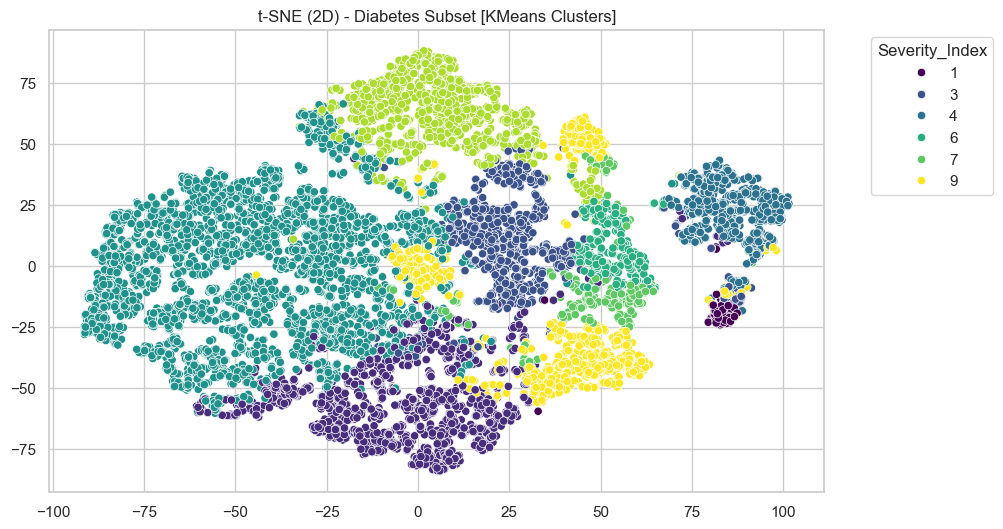

c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


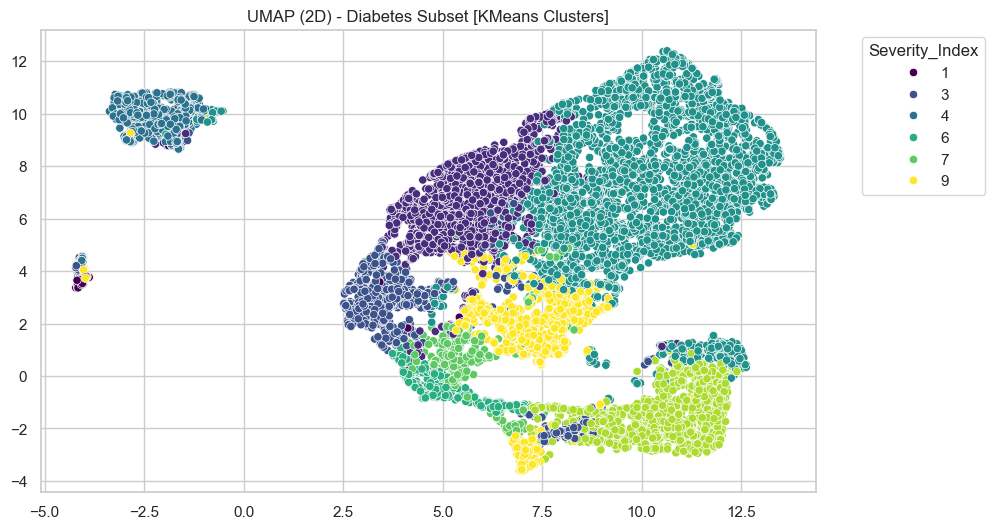

In [8]:
# -----------------------------------------------------------------------------
# 9) 2D t-SNE and UMAP Visualizations
# -----------------------------------------------------------------------------
tsne_2d = TSNE(n_components=2, random_state=42)
tsne_2d_res = tsne_2d.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
sns.scatterplot(
    x=tsne_2d_res[:,0], y=tsne_2d_res[:,1],
    hue=data_merged['Severity_Index'],
    palette='viridis'
)
plt.title(f"t-SNE (2D) - Diabetes Subset [{best_method} Clusters]")
plt.legend(title='Severity_Index', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

umap_2d = umap.UMAP(n_components=2, random_state=42)
umap_2d_res = umap_2d.fit_transform(X_scaled)
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=umap_2d_res[:,0], y=umap_2d_res[:,1],
    hue=data_merged['Severity_Index'],
    palette='viridis'
)
plt.title(f"UMAP (2D) - Diabetes Subset [{best_method} Clusters]")
plt.legend(title='Severity_Index', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [9]:
# -----------------------------------------------------------------------------
# 10) Statistical Tests Across Clusters
# -----------------------------------------------------------------------------
clusters = data_merged['Cluster'].unique()
normality_pvals = []
for c in clusters:
    grp = data_merged.loc[data_merged['Cluster']==c, 'Predicted_Health_Index']
    stat, p_val = shapiro(grp)
    normality_pvals.append(p_val)

if any(p < 0.05 for p in normality_pvals):
    # Kruskal-Wallis
    groups = [data_merged.loc[data_merged['Cluster']==c, 'Predicted_Health_Index'] for c in clusters]
    kw_stat, kw_p = kruskal(*groups)
    print(f"Kruskal-Wallis: H={kw_stat:.4f}, p={kw_p:.4g}")
else:
    # Check variance with Levene
    groups = [data_merged.loc[data_merged['Cluster']==c, 'Predicted_Health_Index'] for c in clusters]
    lv_stat, lv_p = levene(*groups)
    if lv_p < 0.05:
        kw_stat, kw_p = kruskal(*groups)
        print(f"Kruskal-Wallis (variance mismatch): H={kw_stat:.4f}, p={kw_p:.4g}")
    else:
        f_stat, f_p = f_oneway(*groups)
        print(f"ANOVA: F={f_stat:.4f}, p={f_p:.4g}")


Kruskal-Wallis: H=11.7724, p=0.1617


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


=== 3D K-Means Clustering Metrics (6..9) ===


,n_clusters,silhouette,calinski_harabasz,davies_bouldin,avg_rank
0,6,0.414838,10545.053900,0.891875,3.666667
1,7,0.411868,11013.828551,0.883195,3.333333
2,8,0.422543,11461.753038,0.786301,1.333333
3,9,0.415539,11529.241838,0.806819,1.666667


Chosen #clusters for 3D embedding = 8


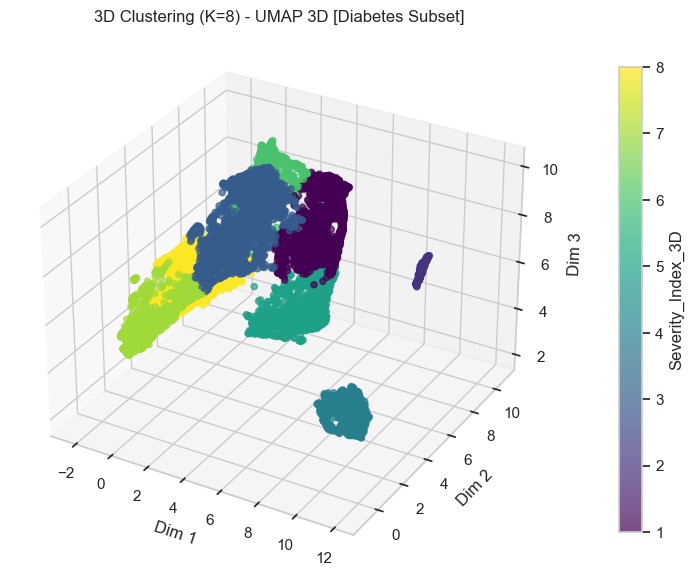

Final 3D KMeans => silhouette=0.423, CH=11461.8, DB=0.786


In [10]:
# -----------------------------------------------------------------------------
# 11) 3D Embedding & Clustering (UMAP or t-SNE)
# -----------------------------------------------------------------------------
tsne_3d = TSNE(n_components=3, random_state=42)
tsne_3d_res = tsne_3d.fit_transform(X_scaled)

umap_3d = umap.UMAP(n_components=3, random_state=42)
umap_3d_res = umap_3d.fit_transform(X_scaled)

# Choose which 3D embedding you want:
embedding_3d = umap_3d_res  # or tsne_3d_res

cluster_range_3d = range(6, 10)
kmeans_3d_metrics = []
for k_3d in cluster_range_3d:
    kmeans_3d = KMeans(n_clusters=k_3d, random_state=42)
    labels_3d = kmeans_3d.fit_predict(embedding_3d)
    s_3d = silhouette_score(embedding_3d, labels_3d)
    ch_3d = calinski_harabasz_score(embedding_3d, labels_3d)
    db_3d = davies_bouldin_score(embedding_3d, labels_3d)
    kmeans_3d_metrics.append({
        'n_clusters': k_3d,
        'silhouette': s_3d,
        'calinski_harabasz': ch_3d,
        'davies_bouldin': db_3d
    })

df_3d_eval = pd.DataFrame(kmeans_3d_metrics)
df_3d_eval['sil_rank'] = df_3d_eval['silhouette'].rank(ascending=False)
df_3d_eval['ch_rank'] = df_3d_eval['calinski_harabasz'].rank(ascending=False)
df_3d_eval['db_rank'] = df_3d_eval['davies_bouldin'].rank(ascending=True)
df_3d_eval['avg_rank'] = df_3d_eval[['sil_rank','ch_rank','db_rank']].mean(axis=1)

best_3d_idx = df_3d_eval['avg_rank'].idxmin()
best_k_3d = df_3d_eval.loc[best_3d_idx, 'n_clusters']

print("=== 3D K-Means Clustering Metrics (6..9) ===")
display(df_3d_eval[['n_clusters','silhouette','calinski_harabasz','davies_bouldin','avg_rank']])
print(f"Chosen #clusters for 3D embedding = {best_k_3d}")

kmeans_final_3d = KMeans(n_clusters=best_k_3d, random_state=42)
final_labels_3d = kmeans_final_3d.fit_predict(embedding_3d)

data_merged['Cluster_3D'] = final_labels_3d
cluster_map_3d = (data_merged
    .groupby('Cluster_3D')['Predicted_Health_Index']
    .mean()
    .sort_values()
    .reset_index()
)
cluster_map_3d['Severity_Index_3D'] = range(1, len(cluster_map_3d)+1)
mapping_3d = cluster_map_3d.set_index('Cluster_3D')['Severity_Index_3D'].to_dict()
data_merged['Severity_Index_3D'] = data_merged['Cluster_3D'].map(mapping_3d)

# 3D Plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
scatter_3d = ax.scatter(
    embedding_3d[:,0], embedding_3d[:,1], embedding_3d[:,2],
    c=data_merged['Severity_Index_3D'], cmap='viridis', alpha=0.7
)
ax.set_title(f"3D Clustering (K={best_k_3d}) - UMAP 3D [Diabetes Subset]")
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
ax.set_zlabel("Dim 3")

cbar = plt.colorbar(scatter_3d, ax=ax, fraction=0.03, pad=0.09)
cbar.set_label("Severity_Index_3D")
plt.show()

# Optional final metrics
def cluster_scores_3d(data_3d, lbls_3d):
    if len(set(lbls_3d)) < 2:
        return np.nan, np.nan, np.nan
    s = silhouette_score(data_3d, lbls_3d)
    c = calinski_harabasz_score(data_3d, lbls_3d)
    d = davies_bouldin_score(data_3d, lbls_3d)
    return s, c, d

s_3d_final, ch_3d_final, db_3d_final = cluster_scores_3d(embedding_3d, final_labels_3d)
print(f"Final 3D KMeans => silhouette={s_3d_final:.3f}, CH={ch_3d_final:.1f}, DB={db_3d_final:.3f}")
